<a href="https://colab.research.google.com/github/ramkamal2000/cs6910_assignment3/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [86]:
import pickle
import pandas as pd
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
import difflib
import seaborn as sns

from nltk import edit_distance
from collections import Counter
import itertools

# Download Dataset

In [3]:
!wget -nc https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

if not os.path.isdir('/content/dakshina_dataset_v1.0'):
  tarfile.open("/content/dakshina_dataset_v1.0.tar").extractall()

File ‘dakshina_dataset_v1.0.tar’ already there; not retrieving.



# Load Dataset

In [4]:
class data_loader():

  @staticmethod
  def _load_raw_df(languages = ["ta"]):
    lex = dict()
    lex['train'], lex['val'], lex['test'] = [], [], [] 
    column_names = ['output', 'input', 'count']
    
    for la in languages:
      lex['train'].append(pd.read_csv('/content' + '/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.train.tsv', sep='\t', header=None, names=column_names))
      lex['val'].append(pd.read_csv('/content' + '/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.dev.tsv', sep='\t', header=None, names=column_names))
      lex['test'].append(pd.read_csv('/content' + '/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.test.tsv', sep='\t', header=None, names=column_names))

    lex['train'] = pd.concat(lex['train'])
    lex['val'] = pd.concat(lex['val'])
    lex['test'] = pd.concat(lex['test'])

    return lex    

  @staticmethod
  def _make_final_df(lex):
    
    for div in ['train', 'val']:
    
      # removing non max transliterations
      idx = lex[div].groupby(['input'])['count'].transform(max) == lex[div]['count']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # calclulating difference in lengths of various transliterations
      lex[div]['input_len'] = lex[div].apply(lambda x: len(str(x['input'])), axis=1)
      lex[div]['output_len'] = lex[div].apply(lambda y: len(str(y['output'])), axis=1)
      lex[div]['mod_dif'] = lex[div].apply(lambda z: abs(z['input_len'] - z['output_len']), axis=1) 

      # removing transliterations that vary by a lot in length
      idx = lex[div].groupby(['input'])['mod_dif'].transform(min) == lex[div]['mod_dif']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # removing duplicates if any remain
      lex[div].drop_duplicates(subset='input', keep='first', inplace=True)

      # removing redundant columns
      lex[div].drop(labels=['count', 'input_len', 'output_len', 'mod_dif'], inplace=True, axis=1)

      # shuffling the dataset i.e. rows of the dataset
      lex[div] = lex[div].sample(frac=1, random_state=6910)
      lex[div] = lex[div].reset_index(drop=True)

    lex['test'] = lex['test'].sample(frac=1, random_state=6910)
    lex['test'].drop(labels=['count'], axis=1, inplace=True)
    lex['test'] = lex['test'].reset_index(drop=True)
    return lex

  @staticmethod
  def _generate_batch(X, y, data_dict, num_decoder_tokens, batch_size = 1):

    while True:
        for j in range(0, len(X), batch_size):
            
            # placeholder data structures
            encoder_input_data = np.zeros((batch_size, data_dict['max_source_length']),dtype='float32')
            decoder_input_data = np.zeros((batch_size, data_dict['max_target_length']),dtype='float32')
            decoder_target_data = np.zeros((batch_size, data_dict['max_target_length'], num_decoder_tokens),dtype='float32')

            # assessing one batch at a time
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):

                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t<len(target_text)-1:
                        # decoder input sequence
                        # does not include the <EOW> token
                        decoder_input_data[i, t] = word 
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the <SOW> token
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

  @staticmethod
  def _generate_batch_greedy(X, y, data_dict, num_decoder_tokens, batch_size = 1):

    while True:
        for j in range(0, len(X), batch_size):

            # placeholder data structures
            encoder_input_data = np.zeros((batch_size, data_dict['max_source_length']),dtype='float32')
            decoder_input_data = np.zeros((batch_size, 1),dtype='float32')
            decoder_target_data = np.zeros((batch_size, data_dict['max_target_length'], num_decoder_tokens),dtype='float32')
            
            # assessing one batch at a time
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t==0 :
                        decoder_input_data[i, t] = 1 # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [5]:
class Tokenizer:

  def __init__(self, df):

    self.start_token = '<SOW>'
    self.stop_token = '<EOW>'
    self.unknown_token = '<UNK>'

    self.input_corpus = [self.start_token, self.stop_token, self.unknown_token]
    self.output_corpus = [self.start_token, self.stop_token, self.unknown_token]

    input_words = df.input.tolist()
    output_words = df.output.tolist()

    for word in input_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.input_corpus:
          self.input_corpus.append(token)

    for word in output_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.output_corpus:
          self.output_corpus.append(token)
    
    self.encode_dict_input = {self.input_corpus[i] : i+1 for i in range(len(self.input_corpus))}
    self.decode_dict_input = {k:v for v,k in self.encode_dict_input.items()}
    
    
    self.encode_dict_output = {self.output_corpus[i] : i+1 for i in range(len(self.output_corpus))}
    self.decode_dict_output = {k:v for v,k in self.encode_dict_output.items()}
    self.decode_dict_output.update({2:''})

  # takes in lists of words and returns lists of integers
  def encode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for word in X:
        word = str(word)
        integer_list =np.array([self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word])
        input_list.append(integer_list)
      
      return input_list
    
    if (mode=='output'):
      output_list = []
      for word in X:
        word = str(word)
        integer_list = np.array([self.encode_dict_output[self.start_token]] + [self.encode_dict_output.get(token, self.encode_dict_output[self.unknown_token]) for token in word] + [self.encode_dict_output[self.stop_token]])
        output_list.append(integer_list)
      
      return output_list
    
  # takes in lists of integers and returns lists of words
  def decode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for integers in X:
        token_list = [self.decode_dict_input.get(integer, '') for integer in integers] 
        input_list.append(''.join(token_list))
      
      return input_list

    if (mode=='output'):
      output_list = []
      for integers in X:
        token_list = [self.decode_dict_output.get(integer, '') for integer in integers[:-1]] 
        output_list.append(''.join(token_list))
      
      return output_list

In [6]:
def return_data_dict(languages=["ta"], batch_size=32):

  lex = data_loader._load_raw_df(languages)
  lex = data_loader._make_final_df(lex)

  data_dict = dict()

  df_train = lex['train']
  df_val = lex['val']
  df_test = lex['test']

  tk = Tokenizer(df_train)

  data_dict['in_size'] = len(tk.input_corpus) + 1
  data_dict['out_size'] = len(tk.output_corpus) + 1

  X_train = tk.encode(df_train.input.tolist(), mode='input')
  Y_train = tk.encode(df_train.output.tolist(), mode='output')
  
  X_val = tk.encode(df_val.input.tolist(), mode='input')
  Y_val = tk.encode(df_val.output.tolist(), mode='output')
  
  X_test = tk.encode(df_test.input.tolist(), mode='input')
  Y_test = tk.encode(df_test.output.tolist(), mode='output')


  data_dict['train'], data_dict['val'], data_dict['test']= dict(), dict(), dict()


  data_dict['train']['df'] = df_train
  data_dict['val']['df'] = df_val
  data_dict['test']['df'] = df_test


  data_dict['train']['max_source_length'] = np.max(np.array([len(x) for x in X_train]))
  data_dict['train']['max_target_length'] = np.max(np.array([len(x) for x in Y_train]))
  
  data_dict['val']['max_source_length'] = np.max(np.array([len(x) for x in X_val]))
  data_dict['val']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))
  
  data_dict['test']['max_source_length'] = np.max(np.array([len(x) for x in X_test]))
  data_dict['test']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))


  data_dict['max_source_length'] = max(data_dict['train']['max_source_length'], data_dict['val']['max_source_length'], data_dict['test']['max_source_length'])
  data_dict['max_target_length'] = max(data_dict['train']['max_target_length'], data_dict['val']['max_target_length'], data_dict['test']['max_target_length'])


  data_dict['train']['batch'] = data_loader._generate_batch(X_train, Y_train, data_dict, data_dict['out_size'], batch_size)
  data_dict['train']['batch_greedy'] = data_loader._generate_batch_greedy(X_train, Y_train, data_dict, data_dict['out_size'], batch_size)
  
  data_dict['val']['batch'] = data_loader._generate_batch(X_val, Y_val, data_dict, data_dict['out_size'], batch_size)
  data_dict['val']['batch_greedy'] = data_loader._generate_batch_greedy(X_val, Y_val, data_dict, data_dict['out_size'], batch_size)

  data_dict['test']['batch'] = data_loader._generate_batch(X_test, Y_test, data_dict, data_dict['out_size'], batch_size)  
  data_dict['test']['batch_greedy'] = data_loader._generate_batch_greedy(X_test, Y_test, data_dict, data_dict['out_size'], batch_size)    
  data_dict['test']['batch_1'] = data_loader._generate_batch_greedy(X_test, Y_test, data_dict, data_dict['out_size'], 1)

  data_dict['tokenizer'] = tk

  return data_dict

In [7]:
data_dict = return_data_dict()
tk = data_dict['tokenizer']
input_vocab = tk.input_corpus[3:]
len(input_vocab)

26

# RNN w/o Attention Dataset Loading

In [8]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/DL3'

In [36]:
path_rnn_beam = root_dir+'/rnn_beam.csv'
df_rnn_beam = pd.read_csv(path_rnn_beam)
X = df_rnn_beam.X.to_list()
Y_true = df_rnn_beam.Y_pred.to_list()
Y_pred = df_rnn_beam.Y_true.to_list()
match = [1*(a==b) for a,b in zip(Y_true, Y_pred)]

In [38]:
sum(match)/len(match)

0.32415501165501165

In [169]:
path_rnn_greedy = root_dir+'/rnn_greedy.csv'
df_rnn_greedy = pd.read_csv(path_rnn_greedy)
X = df_rnn_greedy.X[0].split(',')
Y_true = df_rnn_greedy.Y_pred[0].split(',')
Y_pred = df_rnn_greedy.Y_true[0].split(',')
match = [1*(a==b) for a,b in zip(Y_true, Y_pred)]

In [170]:
sum(match)/len(match)

0.48155225635748933

In [171]:
df = pd.DataFrame({
    'X' : X,
    'true' : Y_true,
    'pred' : Y_pred,
    'match' : match
})

In [173]:
df.head()

,X,true,pred,match
0,nathikalil,நதிகளில்,நதிகளில்,1
1,kargu,கர்கு,சரக்கு,0
2,paavam,பாவம்,பாவம்,1
3,guraikkum,குறைக்கும்,குரைக்கும்,0
4,suttrulaavin,சுற்றுலாவின்,சுற்றுலாவின்,1


## Length Of English Input

In [174]:
df_2 = df.copy()
df_2['X_len'] = df_2.apply(lambda x: len(x['X']), axis=1)

df_2 = df_2.groupby(['X_len', 'match']).count()
df_2.reset_index(level='match', inplace=True)
df_2.drop(columns=['true', 'pred'], inplace=True)

df_3 = df_2.groupby(level='X_len').sum()
df_3.drop(columns=['match'], inplace=True)
df_3 = df_3.rename(columns={'X': 'total'})

df_2 = df_2.rename(columns={'X': 'count'})

df_4 = pd.concat([df_2, df_3], axis=1)
df_4.reset_index(level='X_len', inplace=True)

len_values = df_4.X_len.unique()
full_dict = df_4.set_index(['X_len', 'match']).to_dict()
count_dict, total_dict = full_dict['count'], full_dict['total']

In [175]:
acc_values = [count_dict.get((len, 1), 0)/total_dict.get((len, 1), 1) for len in len_values] 

Text(0.5, 1.0, 'Accuracy vs Length Of Input')

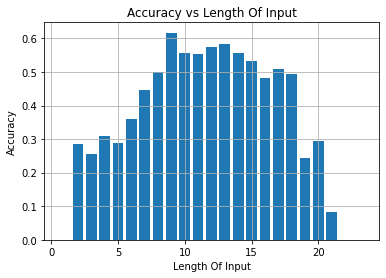

In [176]:
plt.bar(len_values, acc_values)
plt.grid()
plt.xlabel('Length Of Input')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Length Of Input')

## Edit Distance

In [177]:
df_2 = df.copy()
df_2['edit'] = df_2.apply(lambda x: edit_distance(x['true'], x['pred']), axis=1)

df_3 = df_2[df_2['match']==0]
df_3.drop(columns=['match'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 1.0, 'Error F vs ED')

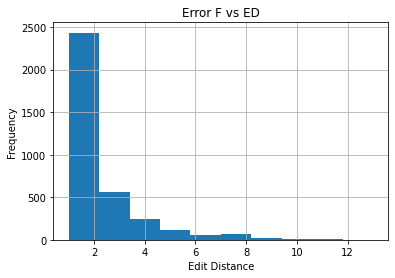

In [178]:
df_3.edit.plot.hist()
plt.grid()
plt.xlabel('Edit Distance')
plt.title('Error F vs ED')

# Tamil Alphabet Wise Accuracy Rate

In [179]:
diff_list = []

for y_true, y_pred in zip(Y_true, Y_pred):
  output_list = [li for li in difflib.ndiff(y_true, y_pred) if li[0] != ' ']
  diff_list += output_list

In [180]:
plus_list, minus_list = [], []

for diff in diff_list:
  if diff[0]=='+':
    plus_list.append(diff[2:])
  else:
    minus_list.append(diff[2:])

net_list = plus_list + minus_list

In [181]:
master_input = []
master_output = []

for word in Y_true:
  master_input += list(word)

for word in Y_pred:
  master_output += list(word)

In [182]:
plus_counter = Counter(plus_list)
minus_counter = Counter(minus_list)
net_counter = Counter(net_list)

master_input_counter = Counter(master_input)
master_output_counter = Counter(master_output)

In [183]:
for key in minus_counter.keys():
  # print(key, minus_counter[key], master_counter[key])
  minus_counter[key] = minus_counter[key] / master_input_counter[key]

for key in plus_counter.keys():
  # print(key, plus_counter[key], master_counter[key])
  plus_counter[key] = plus_counter[key] / master_output_counter[key]

In [184]:
# top 10 - fraction of letters omitted that are mistakes
minus_counter.most_common(10)

[('ஷ', 0.9285714285714286),
 ('ஈ', 0.8333333333333334),
 ('ஐ', 0.625),
 ('ஓ', 0.4375),
 ('ே', 0.3358070500927644),
 ('ூ', 0.3289902280130293),
 ('ண', 0.3242630385487528),
 ('ஸ', 0.2948717948717949),
 ('ெ', 0.26371308016877637),
 ('எ', 0.2558139534883721)]

In [185]:
# top 10 - fraction of letters outputted that are mistakes
plus_counter.most_common(10)

[('ௌ', 1.0),
 ('ஃ', 1.0),
 ('ஷ', 0.9821428571428571),
 ('ஓ', 0.7857142857142857),
 ('ஈ', 0.6666666666666666),
 ('ஐ', 0.625),
 ('ஏ', 0.5),
 ('ஞ', 0.4864864864864865),
 ('ூ', 0.4197183098591549),
 ('ீ', 0.41638225255972694)]

# "Confusion Matrix"

In [186]:
df_2 = df.copy()
df_2['edit'] = df_2.apply(lambda x: edit_distance(x['true'], x['pred']), axis=1)
df_2['mod_dif'] = df_2.apply(lambda z: abs(len(z['true']) - len(z['pred'])), axis=1)

df_3 = df_2[df_2['edit']==1]
df_3 = df_3[df_3['mod_dif']==0]
df_3.drop(columns=['match', 'edit', 'mod_dif'], inplace=True)

Y1_true = df_3.true.to_list()
Y1_pred = df_3.pred.to_list()

In [187]:
diff_list = []

for y_true, y_pred in zip(Y1_true, Y1_pred):
  output_list = tuple([li for li in difflib.ndiff(y_true, y_pred) if li[0] != ' '])
  diff_list.append(output_list)

In [188]:
hm = np.zeros((len(tk.output_corpus), len(tk.output_corpus)))

for true, pred in diff_list:
  hm[tk.encode_dict_output[true[-1]]][tk.encode_dict_output[pred[-1]]] += 1

In [189]:
df_hm = pd.DataFrame(hm)
df_hm.columns = list(range(1, len(tk.output_corpus)+1))
df_hm.index = list(range(1, len(tk.output_corpus)+1))
df_hm.index.name, df_hm.columns.name = 'True', 'Pred'

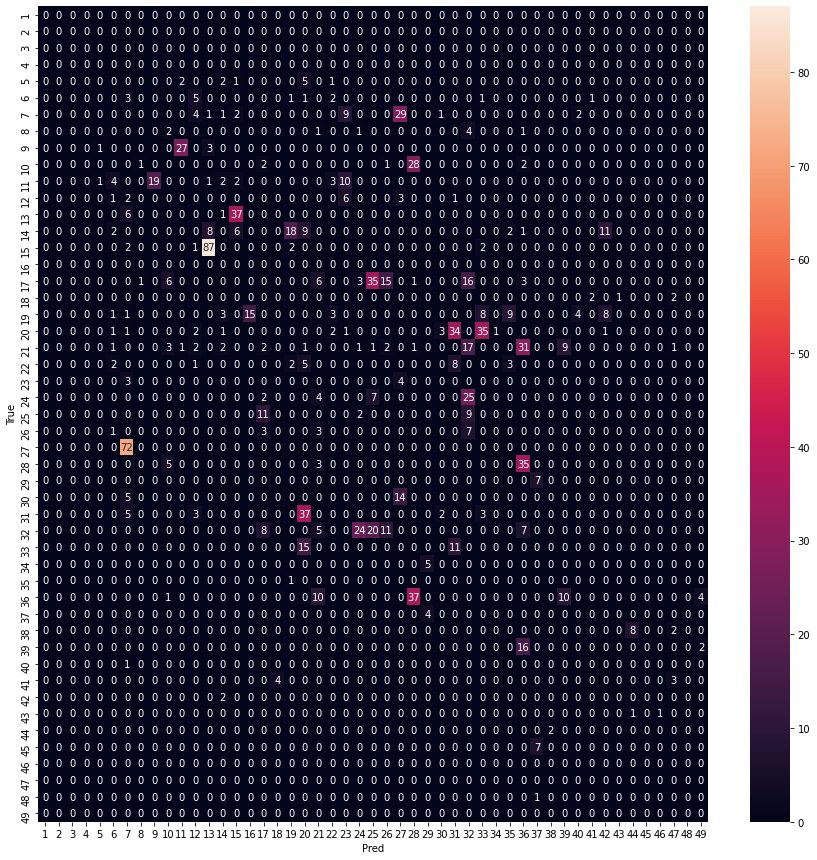

In [190]:
plt.figure(figsize=(15, 15))
fig1 = sns.heatmap(df_hm, annot=True, fmt='g')
plt.show()

In [191]:
one_diff_counter = Counter(diff_list)
one_diff_counter.most_common(20)

[(('- ர', '+ ற'), 87),
 (('- ண', '+ ன'), 72),
 (('- ற', '+ ர'), 37),
 (('- ோ', '+ ூ'), 37),
 (('- ள', '+ ல'), 37),
 (('- ி', '+ ீ'), 35),
 (('- ூ', '+ ோ'), 35),
 (('- ல', '+ ழ'), 35),
 (('- ல', '+ ள'), 34),
 (('- ா', '+ ோ'), 31),
 (('- ன', '+ ண'), 29),
 (('- ு', '+ ூ'), 28),
 (('- ட', '+ த'), 27),
 (('- ெ', '+ ே'), 25),
 (('- ே', '+ ெ'), 24),
 (('- ே', '+ ீ'), 20),
 (('- த', '+ ட'), 19),
 (('- க', '+ ச'), 18),
 (('- ா', '+ ே'), 17),
 (('- ி', '+ ே'), 16)]

## Random Samples

In [192]:
df_2 = df.copy()
df_2['edit'] = df_2.apply(lambda x: edit_distance(x['true'], x['pred']), axis=1)

df_2_wrong = df_2[df_2['match']==0]
df_2_wrong = df_2_wrong.groupby('edit').nth(0)

In [193]:
df_2_wrong

,X,true,pred,match
edit,,,,
1,guraikkum,குறைக்கும்,குரைக்கும்,0
2,kargu,கர்கு,சரக்கு,0
3,committii,காமித்தி,கமிட்டி,0
4,jesus,ஜெஸ்க்,ஜீசஸ்,0
5,nilainiluvaiyil,நிலைநுலையிலில்,நிலுவையில்,0
6,vingngnaanikal,விங்குனாக்கள்,விஞ்ஞானிகள்,0
7,kallurikazhukkana,கல்லுரிக்குகளுக,கல்லூரிகளுக்கான,0
8,padugira,படுகிற,கற்பிக்கப்,0
9,boadhu,போது,முடிக்கும்,0


# Attention Dataset Loading